# IMPORT STATEMENTS

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

# MODEL INPUT DIMENSIONS

In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

# GENERATOR

In [3]:


def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

# Define your image shape and latent dimension
img_shape = (28, 28, 1)
z_dim = 100

# Build the generator model
generator = build_generator(img_shape, z_dim)

# Save the model
generator.save('generator_model.h5')

print("Model saved successfully!")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


# DISCRIMINATOR

In [4]:


def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define the image shape
img_shape = (28, 28, 1)

# Build the discriminator model
discriminator = build_discriminator(img_shape)

# Save the model
discriminator.save('discriminator_model.h5')

print("Discriminator model saved successfully!")


Discriminator model saved successfully!


# BUILDING AND COMPILING THE GAN

In [5]:


def build_gan(generator, discriminator):
    model = Sequential()

    # Combine Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

# Assume generator and discriminator are already built
# For example:
# generator = build_generator(img_shape, z_dim)
# discriminator = build_discriminator(img_shape)

# Build the GAN model
gan = build_gan(generator, discriminator)

# Save the GAN model
gan.save('gan_model.h5')

print("GAN model saved successfully!")


GAN model saved successfully!


In [6]:
from tensorflow.keras.optimizers import Adam

# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Save the Discriminator model after compiling
discriminator.save('compiled_discriminator_model.h5')

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Save the Generator model
generator.save('compiled_generator_model.h5')

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile the GAN model with the fixed Discriminator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Save the GAN model after compiling
gan.save('compiled_gan_model.h5')

print("Discriminator, Generator, and GAN models saved successfully!")


Discriminator, Generator, and GAN models saved successfully!


# GAN TRAINING LOOP

In [7]:
import numpy as np
from tensorflow.keras.datasets import mnist

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        # Save progress and output sample images at intervals
        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated images
            sample_images(generator)

    # Save the models once at the end of training
    generator.save('generator_model_final.h5')
    discriminator.save('discriminator_model_final.h5')
    gan.save('gan_model_final.h5')

    print("All models saved after training!")


# DISPLAYING GENERATED IMAGES

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

# RUNNING THE MODEL

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 2ms/step
18000 [D loss: 0.370261, acc.: 84.77%] [G loss: 2.561571]
4/4 [==============================] - 0s 2ms/step
19000 [D loss: 0.388302, acc.: 82.03%] [G loss: 2.807282]
4/4 [==============================] - 0s 2ms/step
20000 [D loss: 0.386712, acc.: 82.81%] [G loss: 2.580745]
1/1 [==============================] - 0s 26ms/step


All models saved after training!


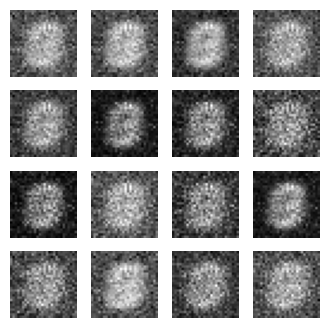

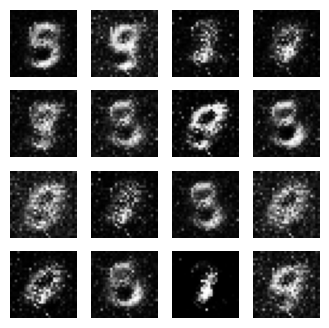

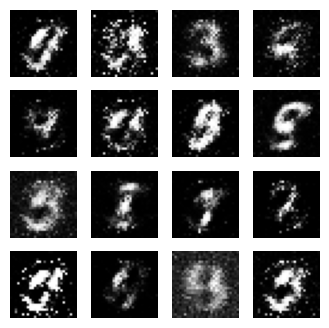

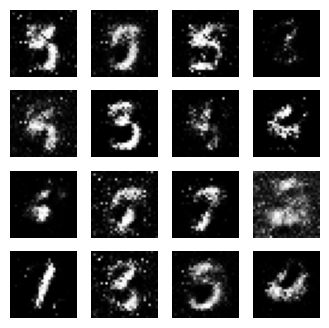

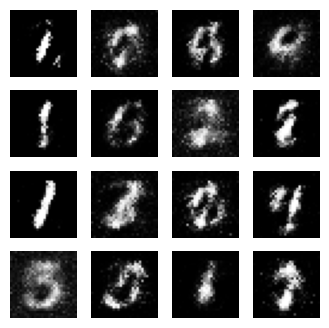

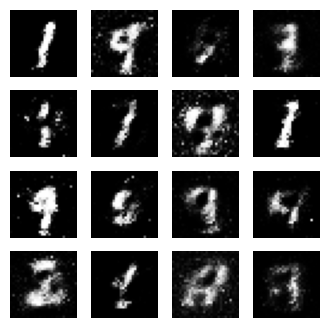

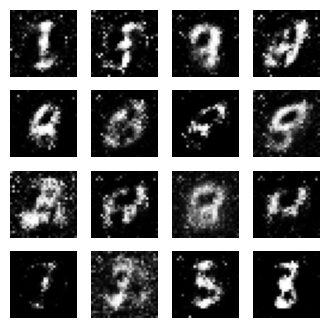

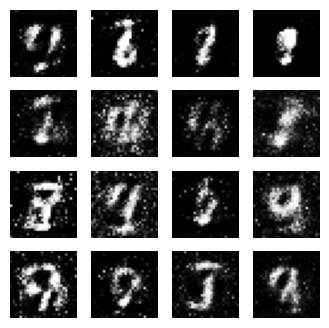

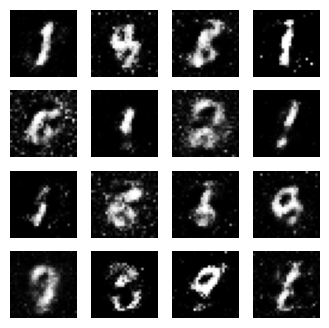

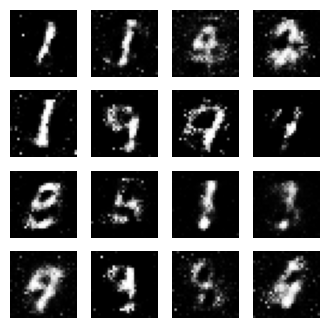

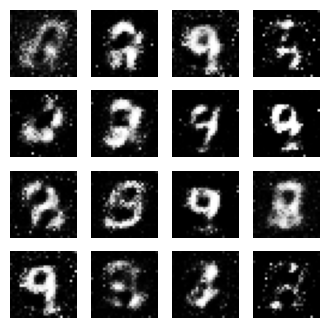

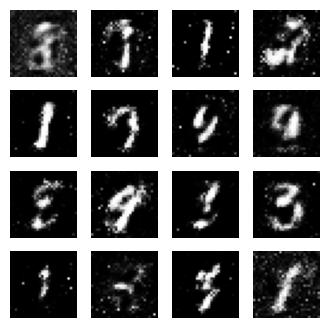

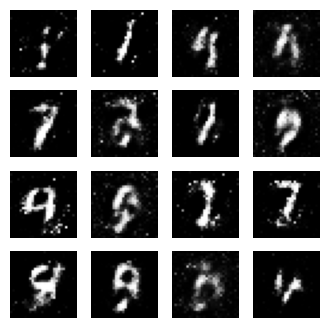

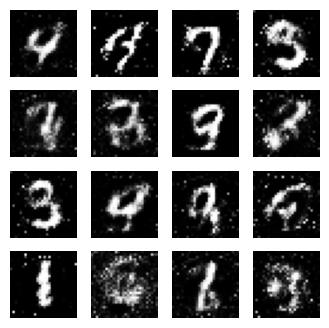

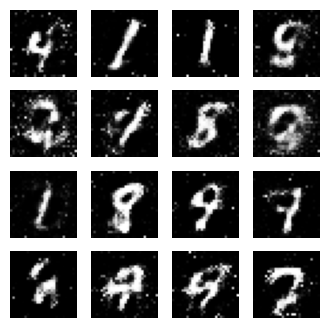

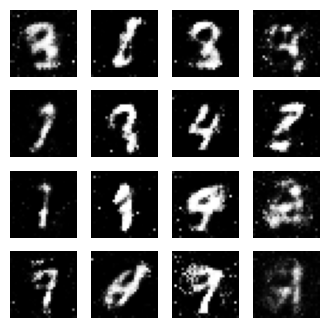

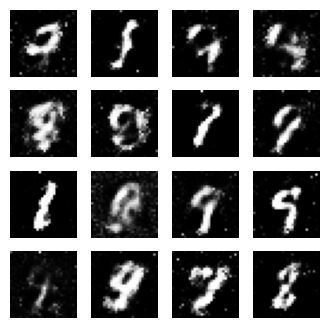

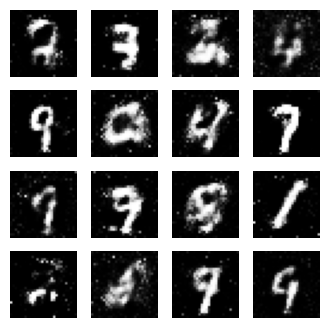

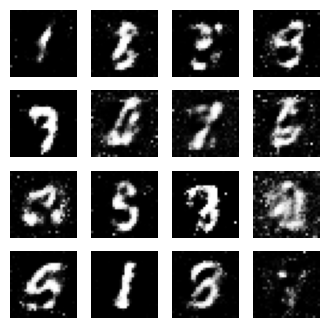

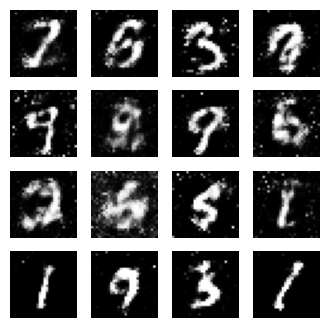

In [9]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)